### P1 Notebook
#### Paul Comitz
---

The pipe line  sequence for this project is:
1. Read image
2. Create gray scale image
3. Perform gaussian blur on gray scale image
4. Perform Canny edge detection on blurred grayscale image
5. Create a region mask 
6. Perform Hough transform 
7. Draw hough lines on color image(s) 
    

##### import the required packages 

In [25]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
#for mp4
from moviepy.editor import VideoFileClip
from IPython.display import HTML

##### grayscale code 

In [26]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


##### Gaussian  blur code 

In [6]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


##### Canny edge detection code 
there are two versions. In the first version the threshold is passed in as a parameter. In the *auto* version the threshold is automatically calculated. 

In [27]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [28]:
def auto_canny(image, sigma=0.33):
    """Applies Canny transform and calculates the threshold"""
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

##### region of interest mask
This component returns a masked image. The mask is identified by the coordinates in list called *vertices*.  Anything outside the region defined by *vertices* is black. 

In [29]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

##### Hough transform code
The Hough transform component makes use of a method called *draw_lines.*. This component is the heart of this project. The Hough transform takes a point in image space. The point is an output of the Canny edge detection component. The Hough transform takes the image space point amd reprsent the point as a line. 
*draw_lines* looks at the slope of each line. If the slope is negative, the line os part of the right  lane. If the slope is positive the line is part of the left lane. Note that this is counter intuitive. The slope for the left lane is positive because the y axis is positive down. 

In [30]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=11):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    y_min = 320
    y_max = img.shape[0]
    
    l_slope = []
    r_slope = []
    
    l_lane = np.empty([0,2],int)
    r_lane = np.empty([0,2],int)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # calculate the slope
            m = ((y2-y1)/(x2-x1))
            
            # filter the slope for left lane
            if m > -5 and m < -0.5:
                l_slope.append(m)
                l_lane= np.append(l_lane,[[x1,y1],[x2,y2]], axis = 0)
                
            # filter the slope for right lane    
            elif m > 0.5 and m < 5:
                r_slope.append(m)
                r_lane= np.append(r_lane,[[x1,y1],[x2,y2]], axis = 0)
    
    # mean slope left lane
    l_slopemean = np.mean(l_slope) 
    # mean x and y left lane
    l_mean = np.mean(l_lane, axis = 0)
    
    # filter for frame where no lines are detected
    if len(l_slope)>0:
        left_b = l_mean[1] - l_slopemean*l_mean[0]

        left_x1 = int((y_min - left_b)/l_slopemean)
        left_x2 = int((y_max - left_b)/l_slopemean)

        cv2.line(img, (left_x1, y_min), (left_x2, y_max), color, thickness)
    
    # mean slope right lane
    r_slopemean = np.mean(r_slope)
    # mean x and y left lane
    r_mean = np.mean(r_lane, axis = 0)
    
    # filter for frame where no lines are detected
    if len(r_slope)>0:
        right_b = r_mean[1] - r_slopemean*r_mean[0]
        right_x1 = int((y_min - right_b)/r_slopemean)
        right_x2 = int((y_max - right_b)/r_slopemean)

        cv2.line(img, (right_x1, y_min), (right_x2, y_max), color, thickness)
                

###### hough_lines calls draw_lines

In [31]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


##### weighted image 
returns the color image with the lane lines drawn on the image


In [32]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

##### process_image is used in the mp4 processing. 
This is conveninece component that aggrgates the software pipeline. 

In [33]:
def process_image(image):
    
    gray = grayscale(image)

    # Apply gaussian smoothing and canny edge detection
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 50, 150)

    # Create masked edges and define vertices
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    hough_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    line_edges = weighted_img(hough_edges, image)

    #plt.imshow(line_edges)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return line_edges

##### turn the crank
the code blocks below manually break out and highlight each step in the software pipeline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


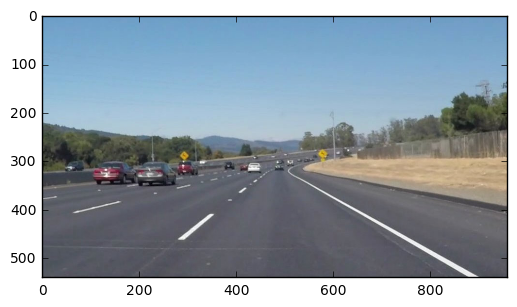

In [34]:
#read  in an image
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.show()     
   

In [ ]:
do the gray scale 

doing grayscale


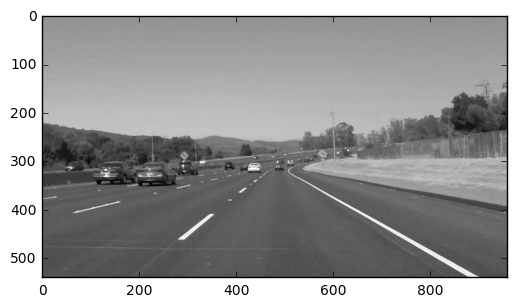

In [35]:
print("doing grayscale")
gray = grayscale(image)
plt.imshow(gray, cmap = 'gray') 
plt.show() 

In [ ]:
do the gaussian blur

doing blur


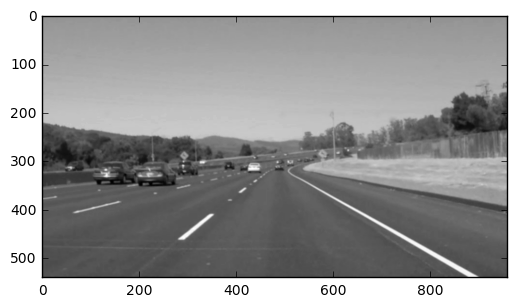

In [36]:
#doing blur 
print("doing blur")
kernel_size = 5
blur = gaussian_blur(gray,kernel_size)
plt.imshow(blur,cmap = 'gray')
plt.show()


In [ ]:
do the canny edge detection

doing auto canny


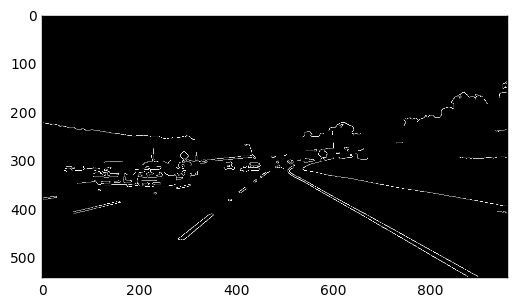

In [37]:
#do canny
print("doing auto canny")
edges = auto_canny(blur)
plt.imshow(edges,cmap = 'gray')
plt.show()

In [ ]:
do image mask 

doing mask


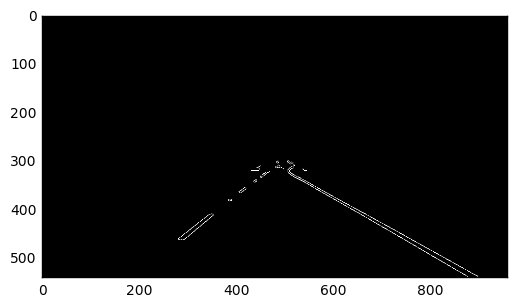

In [38]:
#do mask 
print("doing mask")
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(490, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
mask = region_of_interest(edges,vertices)
plt.imshow(mask,cmap = 'gray')
plt.show()

In [ ]:
do hough transfrom

doing hough


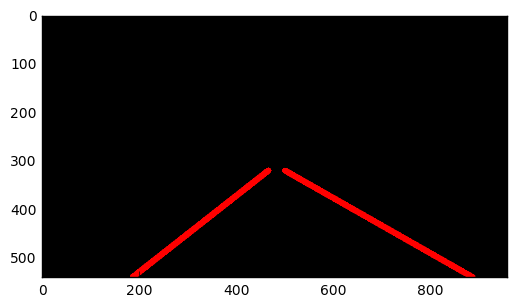

In [39]:
#do hough lines
print("doing hough")
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 70     # phc 10 tweaked minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 # phc 30 tweaked minimum number of pixels making up a line
max_line_gap = 20    # phc 10 tweaked maximum gap in pixels between connectable line segments
#line_image = hough_lines(mask,rho,theta,min_line_length, max_line_gap)
line_image=hough_lines(mask, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(line_image,cmap = 'gray')
plt.show()

doing combo, drum roll please .....


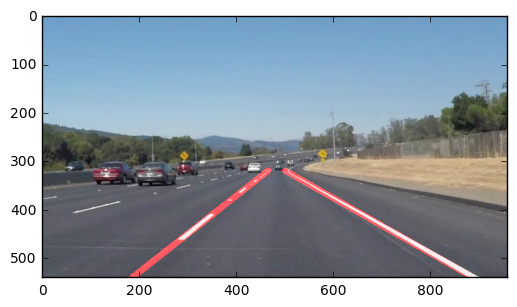

In [40]:
#doing combo
print("doing combo, drum roll please .....")
combo = cv2.addWeighted(line_image, 0.8, image, 1, 0) 
#combo2 = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(combo)
plt.show()


##### Test with video 

In [41]:
white_output = 'white.mp4'
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


MoviePy: building video file white.mp4
----------------------------------------

Writing video into white.mp4
|----------| 0/213   0% [elapsed: 00:00 left: ?, ? iters/sec]

H:\Program Files\Anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Done writing video in white.mp4 !
Your video is ready !
Wall time: 7.05 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

try the yellow output

In [43]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)

%time yellow_clip.write_videofile(yellow_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))


MoviePy: building video file yellow.mp4
----------------------------------------

Writing video into yellow.mp4
|----------| 0/654   0% [elapsed: 00:00 left: ?, ? iters/sec]

H:\Program Files\Anaconda3\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
H:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
H:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
H:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done writing video in yellow.mp4 !
Your video is ready !
Wall time: 25.9 s


### Reflections

This was an interesting first assignment. There were a number of significant challenges. 
1. There were not enough examples or explanations of the image processing techniques and algorithms. For example Canny Edge Detection and Hough transforms were covered in a about two minutes each. This is not a sufficient presentation. To really understand these, and be able to apply these techniques, independent outside study, with other materials is required. 
    a. In order to really understand the Hough transform I found it necessary to read several papers, watch several videos, and do a series of plots and examples. It would have been useful to show that a point in x,y space maps to a variable y intercept (b axis) and a variable slope (m axis) in Hough Space. 
    
2. It would have been useful to show some of the mechanics of the python code. Some of the code is a little tricky and needed just a little explanation. It is of course possible to looks around and find many python tutorials. Udacity could have assisted with this by including some relevant links or providing some walkthroughs. 
    a. All of the examples leading up to the project used images. There should have been a discussion or some examples of processing using video. 

3. There was no discussion of the tools and the computing environment, until project time. Some recitations or tutorials with would Anaconda, Jupyter, Spyder, and Docker would be useful. As above, the student must go to outside sources to find this information on how to use these tools. 

4. Information was spread out in too many places. Some information is in on the Udacity site, some is on Github in the notebook, some is on Github in the read me, some is in tech Atlassian forum wit a separate login. The student is required to hunt around in multiple sites (where did I see that again). It's easy to forget and easy to lose information.

5. Despite the instructional problems, the pipeline was nicely illustrated. As indicated in the opening paragraph of this notebook, the pipleine is: 
    a. Read image or video 
    b. Create gray scale image
    c. Perform gaussian blur on gray scale image
    d. Perform Canny edge detection on blurred grayscale image
    e. Create a region mask 
    f. Perform Hough transform. The transform component makes use of a utility method that determine of the slope of the lines in Hough Space (where each line corresponds to a point in image space. The points are the outputs of the Canny edge detection process. 
    g. Draw lines on color image(s) or videos
    
 All in all a useful project.   